## Modeling
### Experiments with XGBoost for Forecasting Stocks

**Objetivo**: O objetivo deste notebook é fazer experimentos de modelagem com o modelo XGBoost, que será construido de forma iterativa (1 step-ahead forecast)



**Conclusões**:


### 1.0 Imports

In [1]:
%pip install xgboost
%pip install statsmodels
%pip install mlflow
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import logging
from joblib import load, dump
#from pandas_profiling import ProfileReport

# Time Series Libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  #Autocorrelação (MA), Autocorrelatcao parcial (AR)ve
from pmdarima.arima.utils import ndiffs 

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

from scipy.stats import shapiro, normaltest, kstest

import mlflow

In [16]:
import warnings
warnings.filterwarnings('ignore')

### 2.0 Definindo Parâmetros

In [3]:
model_config = {
    "TEST_SIZE": 0.2,
    "TARGET_NAME": "Close",
    "VALIDATION_METRIC": "MAPE",
    "OPTIMIZATION_METRIC": "MAE",
    "FORECAST_HORIZON": 14,
    "REGISTER_MODEL_NAME": "Stock_Predictor"
}

features_list = ["day_of_month", "month", "quarter", "Close_lag_1"]
run_name = "Experiment_run"

# Define a ação para procurar
STOCK_NAME = 'BOVA11.SA'

In [4]:
log_format = "[%(name)s][%(levelname)-6s] %(message)s"
logging.basicConfig(format=log_format)
logger = logging.getLogger("describe")
logger.setLevel(logging.INFO)

### 3.0 Criando Funções

In [5]:
def build_features(raw_df: pd.DataFrame, features_list: list) -> pd.DataFrame:
    """
    This function creates the features for the dataset to be consumed by the
    model
    
    :param raw_df: Raw Pandas DataFrame to create the features of
    :param features_list: The list of features to create

    :return: Pandas DataFrame with the new features
    """

    logger.info("Building the features...")

    stock_df_featurized = raw_df.copy()
    for feature in features_list:
        
        # create "Time" features
        if feature == "day_of_month":
            stock_df_featurized['day_of_month'] = stock_df_featurized["Date"].apply(lambda x: float(x.day))
        elif feature == "month":
            stock_df_featurized['month'] = stock_df_featurized['Date'].apply(lambda x: float(x.month))
        elif feature == "quarter":
            stock_df_featurized['quarter'] = stock_df_featurized['Date'].apply(lambda x: float(x.quarter))

    # Create "Lag" features
    # The lag 1 feature will become the main regressor, and the regular "Close" will become the target.
    # As we saw that the lag 1 holds the most aucorrelation, it is reasonable to use it as the main regressor.
        elif feature == "Close_lag_1":
            stock_df_featurized['Close_lag_1'] = stock_df_featurized['Close'].shift()


    # Drop nan values because of the shift
    stock_df_featurized = stock_df_featurized.dropna()

    # Save the dataset
    stock_df_featurized.to_csv("../data/processed/processed_stock_prices.csv", index=False)

    return stock_df_featurized

In [6]:
def ts_train_test_split(data: pd.DataFrame, target:str, test_size: int):
    """
    Splits the Pandas DataFrame into training and tests sets
    based on a Forecast Horizon value.

    Paramteres:
        data (pandas dataframe): Complete dataframe with full data
        targer (string): the target column name
        test_size (int): the amount of periods to forecast

    Returns:
        X_train, X_test, y_train, y_test dataframes for training and testing
    """

    logger.info("Spliting the dataset...")

    train_df = data.iloc[:-test_size, :]
    test_df = data.iloc[-test_size:, :]
    X_train = train_df.drop(target, axis=1)
    y_train = train_df[target]
    X_test = test_df.drop(target, axis=1)
    y_test = test_df[target]

    return X_train, X_test, y_train, y_test

In [7]:
def visualize_validation_results(pred_df: pd.DataFrame, model_mape: float, model_rmse: float, model_wape: float):
    """
    Creates visualizations of the model validation

    Paramters:
        pred_df: DataFrame with true values, predictions and the date column
        model_mape: The validation MAPE
        model_rmse: The validation RMSE

    Returns:
        None
    """

    logger.info("Vizualizing the results...")

    fig, axs = plt.subplots(figsize=(12, 5))
    # Plot the Actuals
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Actual",
        label="Testing values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Actual",
        ax=axs,
        size="Actual",
        sizes=(80, 80), legend=False
    )

    # Plot the Forecasts
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        label="Forecast values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        ax=axs,
        size="Forecast",
        sizes=(80, 80), legend=False
    )

    axs.set_title(f"Default XGBoost {model_config['FORECAST_HORIZON']} days Forecast for {STOCK_NAME}\nMAPE: {round(model_mape*100, 2)}% | MAE: R${model_rmse} | WAPE: {model_wape}")
    axs.set_xlabel("Date")
    axs.set_ylabel("R$")

    #plt.savefig(f"./reports/figures/XGBoost_predictions_{dt.datetime.now().date()}.png")
    plt.show()

In [8]:
def visualize_forecast(pred_df: pd.DataFrame, historical_df: pd.DataFrame, stock_name: str):
    """
    Creates visualizations of the model forecast

    Paramters:
        pred_df: DataFrame with true values, predictions and the date column
        historical_df: DataFrame with historical values

    Returns:
        None
    """

    logger.info("Vizualizing the results...")

    fig, axs = plt.subplots(figsize=(12, 5), dpi = 200)
    # Plot the Actuals
    sns.lineplot(
        data=historical_df,
        x="Date",
        y="Close",
        label="Historical values",
        ax=axs
    )
    sns.scatterplot(
        data=historical_df,
        x="Date",
        y="Close",
        ax=axs,
        size="Close",
        sizes=(80, 80),
        legend=False
    )

    # Plot the Forecasts
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        label="Forecast values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        ax=axs,
        size="Forecast",
        sizes=(80, 80),
        legend=False
    )

    axs.set_title(f"Default XGBoost {model_config['FORECAST_HORIZON']-4} days Forecast for {stock_name}")
    axs.set_xlabel("Date")
    axs.set_ylabel("R$")

    plt.show()
    return fig

In [9]:
def train_model(X_train: pd.DataFrame,  y_train: pd.DataFrame, random_state:int=42):
    """
    Trains a XGBoost model for Forecasting
    
    :param X_train: Training Features
    :param y_train: Training Target

    :return: Fitted model
    """
    logger.info("Training the model...")
    
    params = {
        'colsample_bytree': 1.0,
        'n_estimators': 40,
     }

    # create the model
    xgboost_model = xgb.XGBRegressor(
        random_state=random_state,
        **params
        )

    # train the model
    xgboost_model.fit(
        X_train,
        y_train,
        )

    # save model
    dump(xgboost_model, f"./{model_config['REGISTER_MODEL_NAME']}_nb.joblib")

    return xgboost_model

In [14]:
def validade_model_one_shot(X:pd.DataFrame, y:pd.Series, forecast_horizon: int) -> pd.DataFrame:
    """
    Make predictions for the next `forecast_horizon` days using a XGBoost model.
    This model is validated using One Shot Training, it means that we train the model
    once, and them perform the `forecast_horizon` predictions only loading the mdoel.
    
    Parameters:
        X (pandas dataframe): The input data
        y (pandas dataframe): The target data
        forecast_horizon (int): Number of days to forecast
        
    Returns:
        pred_df: Pandas DataFrame with the forecasted values
    """

    logger.info("Starting the pipeline..")

    # Create empty list for storing each prediction
    predictions = []
    actuals = []
    dates = []
    
    # get the one-shot training set
    X_train = X.iloc[:-forecast_horizon, :]
    y_train = y.iloc[:-forecast_horizon]

    # train the model once
    xgboost_model = train_model(
        X_train.drop("Date", axis=1),
        y_train
    )

    # Iterate over the dataset to perform predictions over the forecast horizon, one by one.
    # After forecasting the next step, we need to update the "lag" features with the last forecasted
    # value
    for day in range(forecast_horizon-4, 0, -1):
        
        if day != 1:
            # the testing set will be the next day after the training and we use the complete dataset
            X_test = X.iloc[-day:-day+1,:]
            y_test = y.iloc[-day:-day+1]

        else:
            # need to change the syntax for the last day (for -1:-2 will not work)
            X_test = X.iloc[-day:,:]
            y_test = y.iloc[-day:]

        # only the first iteration will use the true value of Close_lag_1
        # because the following ones will use the last predicted value as true value
        # so we simulate the process of predicting out-of-sample
        if len(predictions) != 0:
            
            # we need to update the X_test["Close_lag_1"] value, because
            # it should be equal to the last prediction (the "yesterday" value)
            X_test.iloc[:, -1] = predictions[-1]      

        else:
            pass
    
        # make prediction
        prediction = xgboost_model.predict(X_test.drop("Date", axis=1))
        print(f"Day: {X_test['Date'].max()} | Prediction: {prediction[0]} | Close_Lag_1: {X_test['Close_lag_1'].values[0]}")

        # store the results
        predictions.append(prediction[0])
        actuals.append(y_test.values[0])
        dates.append(X_test["Date"].max())
    
    pred_df = pd.DataFrame(list(zip(dates, actuals, predictions)), columns=["Date", 'Actual', 'Forecast'])
    pred_df["Forecast"] = pred_df["Forecast"].astype("float64")
    
    # Calculate the resulting metric
    model_mape = round(mean_absolute_percentage_error(actuals, predictions), 4)
    model_rmse = round(np.sqrt(mean_squared_error(actuals, predictions)), 2)
    model_mae = round(mean_absolute_error(actuals, predictions), 2)
    model_wape = round((pred_df.Actual - pred_df.Forecast).abs().sum() / pred_df.Actual.sum(), 2)
    
    visualize_validation_results(pred_df, model_mape, model_mae, model_wape)

    return pred_df

## 4.0 Executando

### 4.1 One Shot training and prediction

[describe][INFO  ] Building the features...
[describe][INFO  ] Spliting the dataset...
[describe][INFO  ] Starting the pipeline..
[describe][INFO  ] Training the model...
[describe][INFO  ] Vizualizing the results...


Day: 2023-03-03 00:00:00 | Prediction: 101.05712127685547 | Close_Lag_1: 99.94000244140624
Day: 2023-03-06 00:00:00 | Prediction: 101.22428131103516 | Close_Lag_1: 101.05712127685547
Day: 2023-03-07 00:00:00 | Prediction: 100.45834350585938 | Close_Lag_1: 101.22428131103516
Day: 2023-03-08 00:00:00 | Prediction: 100.34210968017578 | Close_Lag_1: 100.45834350585938
Day: 2023-03-09 00:00:00 | Prediction: 99.98053741455078 | Close_Lag_1: 100.34210968017578
Day: 2023-03-10 00:00:00 | Prediction: 100.16783905029297 | Close_Lag_1: 99.98053741455078
Day: 2023-03-13 00:00:00 | Prediction: 100.02499389648438 | Close_Lag_1: 100.16783905029297
Day: 2023-03-14 00:00:00 | Prediction: 100.34410095214844 | Close_Lag_1: 100.02499389648438
Day: 2023-03-15 00:00:00 | Prediction: 100.51155853271484 | Close_Lag_1: 100.34410095214844
Day: 2023-03-16 00:00:00 | Prediction: 100.1151351928711 | Close_Lag_1: 100.51155853271484


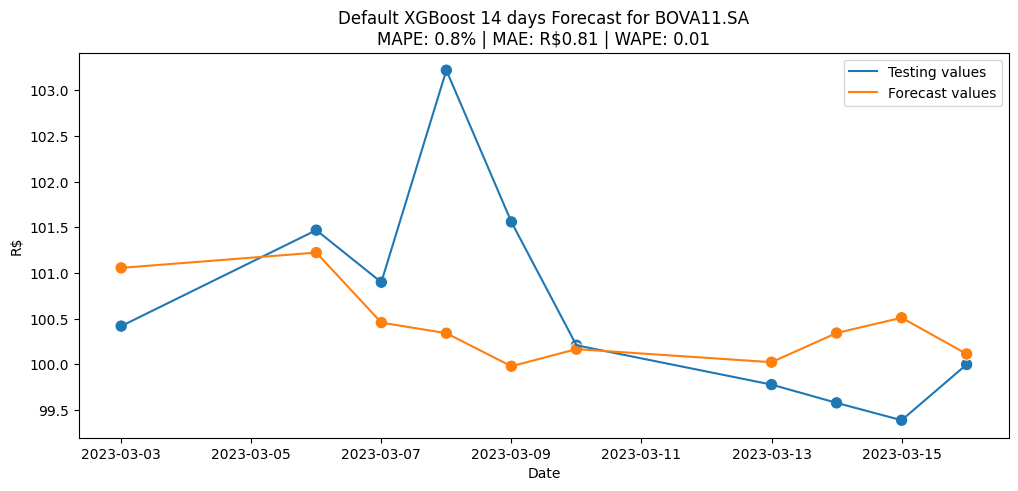

In [17]:
# Load the raw dataset
stock_df = pd.read_csv('../data/raw/raw_stock_prices.csv', parse_dates=["Date"])

# Perform featurization
features_list = ["day_of_month", "month", "quarter", "Close_lag_1"]

stock_df_feat = build_features(stock_df, features_list)

stock_df_feat = stock_df_feat[stock_df_feat["Stock"] == 'BOVA11.SA'].drop("Stock", axis=1)

# train test split
X_train, X_test, y_train, y_test = ts_train_test_split(stock_df_feat, model_config["TARGET_NAME"], model_config["FORECAST_HORIZON"])

# Execute the whole pipeline
predictions_df = validade_model_one_shot(pd.concat([X_train, X_test], axis=0), pd.concat([y_train, y_test], axis=0), model_config['FORECAST_HORIZON'])

In [12]:
predictions_df

,Date,Actual,Forecast
0,2023-03-03,100.419998,101.057121
1,2023-03-06,101.470001,101.224281
2,2023-03-07,100.900002,100.458344
3,2023-03-08,103.220001,100.342110
4,2023-03-09,101.559998,99.980537
5,2023-03-10,100.209999,100.167839
6,2023-03-13,99.779999,100.024994
7,2023-03-14,99.580002,100.344101
8,2023-03-15,99.389999,100.511559
9,2023-03-16,100.000000,100.115135


[describe][INFO  ] Vizualizing the results...


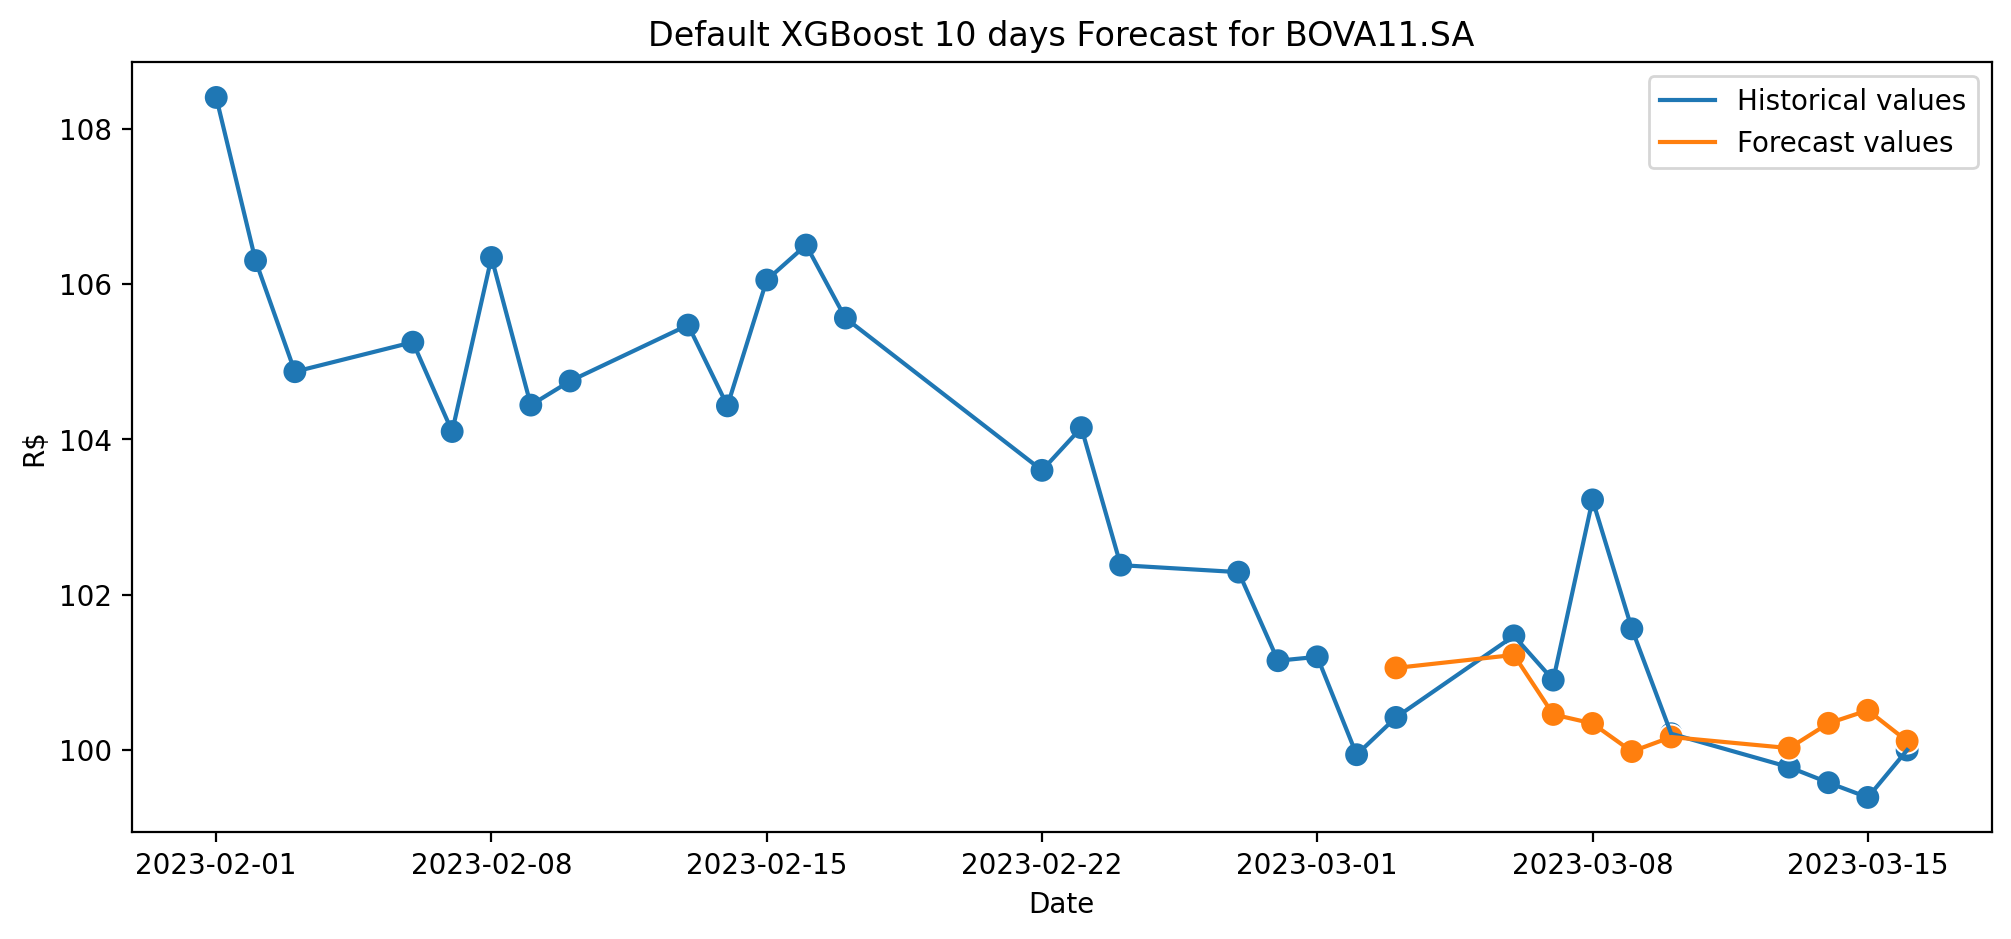

In [13]:
fig = visualize_forecast(predictions_df, stock_df_feat[stock_df_feat["Date"] >= pd.to_datetime('2023-02-01')], 'BOVA11.SA')